In [1]:
from nba_api.stats.endpoints import leaguegamefinder, playbyplayv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

from mar_designs import tidy_axes

In [2]:
# Variables for the notebook
facecolor = "#F7F5F2"
figsize=(11,6)
subplotFigsize=(28,6)
titlesize=16
labelsize=14

pd.set_option('display.max_columns', None)

In [3]:
# Map used for changing the EVENTMSGACTIONTYPE to readable language
actionMap = {
    75: "DRIVING_FINGER_ROLL_LAYUP",
    6: "DRIVING_LAYUP",
    80: "STEP_BACK_JUMP_SHOT",
    79: "PULLUP_JUMP_SHOT",
    103: "RUNNING_PULL_UP_JUMP_SHOT",
    1: "JUMP_SHOT",
    108: "CUTTING_DUNK_SHOT",
    57: "DRIVING_HOOK_SHOT",
    78: "FLOATING_JUMP_SHOT",
    9: "DRIVING_DUNK",
    5: "LAYUP",
    97: "TIP_LAYUP_SHOT",
    86: "TURNAROUND_FADEAWAY",
    73: "DRIVING_REVERSE_LAYUP",
    107: "TIP_DUNK_SHOT",
    98: "CUTTING_LAYUP_SHOT",
    76: "RUNNING_FINGER_ROLL_LAYUP",
    63: "FADEAWAY_JUMPER",
    72: "PUTBACK_LAYUP",
    106: "RUNNING_ALLEY_OOP_DUNK_SHOT",
    41: "RUNNING_LAYUP",
    101: "DRIVING_FLOATING_JUMP_SHOT",
    2: "RUNNING_JUMP_SHOT",
    102: "DRIVING_FLOATING_BANK_JUMP_SHOT",
    58: "TURNAROUND_HOOK_SHOT"
}

# Map used for changing EVENTMSGTYPE to readable language
shotMap = {1:"GOAL", 2:"MISS"}

In [4]:
# Find Nuggets games from the 2023-2024 season
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=1610612743, season_nullable='2023-24')
games = gamefinder.get_data_frames()[0]
nuggets_game_ids = games['GAME_ID'].unique()

In [5]:
# Show features of games dataframe
# games.info()

In [6]:
# Choose a game ID to start with
game_id = nuggets_game_ids[0]  # or loop through several

# Get play-by-play
pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
df = pbp.get_data_frames()[0]
df.to_csv("../data/module2_data/playbyplay_record.csv")

In [7]:
# Features for df of play by play for a single game (this one is against the Twolves)
df.head(3)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0042300237,2,12,0,1,8:07 PM,12:00,None,Start of 1st Period (8:07 PM EST),None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0
1,0042300237,4,10,0,1,8:07 PM,12:00,Jump Ball Jokic vs. Gobert: Tip to Edwards,None,None,None,None,4,203999,Nikola Jokić,1.610613e+09,Denver,Nuggets,DEN,5,203497,Rudy Gobert,1.610613e+09,Minnesota,Timberwolves,MIN,5,1630162,Anthony Edwards,1.610613e+09,Minnesota,Timberwolves,MIN,1
2,0042300237,7,6,4,1,8:07 PM,11:47,None,None,Gobert OFF.Foul (P1) (S.Foster),None,None,5,203497,Rudy Gobert,1.610613e+09,Minnesota,Timberwolves,MIN,4,1627750,Jamal Murray,1.610613e+09,Denver,Nuggets,DEN,1,0,None,NaN,None,None,None,1


## Begin cleaning the dataframe
* drop rows where the action isn't Denver's

In [103]:
# Mask for EVENTMSGTYPE 1 OR 2 -- these are made and missed field goals respectively 
df_shots = df.loc[df["EVENTMSGTYPE"].isin([1,2])]

# Only get plays where Denver is on offense
df_offense = df_shots.loc[df_shots["PLAYER1_TEAM_CITY"] == "Denver"]

df_3 = df_offense[["EVENTMSGTYPE", "PLAYER1_NAME", "PLAYER2_NAME", "PLAYER3_NAME", "EVENTMSGACTIONTYPE", "HOMEDESCRIPTION"]]
shotMadeSeries = df_3["EVENTMSGTYPE"].map(shotMap) 
actionTypeSeries = df_3["EVENTMSGACTIONTYPE"].map(actionMap) 

dfPlayers = df_3.drop(columns=["HOMEDESCRIPTION", "EVENTMSGTYPE", "EVENTMSGACTIONTYPE"], axis=0)
dfPlayers["SHOTSTATUS"] = shotMadeSeries
dfPlayers["SHOTACTION"] = actionTypeSeries

dfPlayers.head()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,PLAYER1_NAME,PLAYER2_NAME,PLAYER3_NAME,SHOTSTATUS,SHOTACTION
4,Jamal Murray,None,None,MISS,DRIVING_FINGER_ROLL_LAYUP
6,Michael Porter Jr.,None,None,MISS,DRIVING_FINGER_ROLL_LAYUP
10,Michael Porter Jr.,None,Rudy Gobert,MISS,DRIVING_LAYUP
12,Jamal Murray,None,None,GOAL,STEP_BACK_JUMP_SHOT
14,Nikola Jokić,None,None,MISS,PULLUP_JUMP_SHOT


In [104]:
# Now, iterate through the rows and grab all values that aren't None, to simulate for transactions
mainList = []
for _, row in dfPlayers.iterrows():
    mainList.append(row.dropna().to_list())

In [105]:
# Save transaction data
with open("../data/module2_data/playbyplay_transactions.csv", "w+") as f:
    for sublist in mainList:
        str_transaction = ",".join(sublist).replace("ć", "c")
        f.write(str_transaction)

In [106]:
# Get mainList into format for mlxtend ARM analysis

te = TransactionEncoder()
te_array = te.fit(mainList).transform(mainList)
one_hot_df = pd.DataFrame(te_array, columns=te.columns_)

one_hot_df.head()

,Aaron Gordon,CUTTING_DUNK_SHOT,CUTTING_LAYUP_SHOT,Christian Braun,DRIVING_DUNK,DRIVING_FINGER_ROLL_LAYUP,DRIVING_FLOATING_BANK_JUMP_SHOT,DRIVING_FLOATING_JUMP_SHOT,DRIVING_HOOK_SHOT,DRIVING_LAYUP,DRIVING_REVERSE_LAYUP,FADEAWAY_JUMPER,FLOATING_JUMP_SHOT,GOAL,JUMP_SHOT,Jaden McDaniels,Jamal Murray,Karl-Anthony Towns,Kentavious Caldwell-Pope,LAYUP,MISS,Michael Porter Jr.,Naz Reid,Nikola Jokić,PULLUP_JUMP_SHOT,PUTBACK_LAYUP,RUNNING_ALLEY_OOP_DUNK_SHOT,RUNNING_FINGER_ROLL_LAYUP,RUNNING_JUMP_SHOT,RUNNING_LAYUP,RUNNING_PULL_UP_JUMP_SHOT,Reggie Jackson,Rudy Gobert,STEP_BACK_JUMP_SHOT,TIP_DUNK_SHOT,TIP_LAYUP_SHOT,TURNAROUND_FADEAWAY,TURNAROUND_HOOK_SHOT
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [151]:
# Apply apriori and association rules for support
frequent_itemsets = apriori(one_hot_df, min_support=0.03, use_colnames=True)

# Find rules for support
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)
supp = rules[["antecedents", "consequents", "support"]].sort_values(by="support", ascending=False)
supp.head(15)

,antecedents,consequents,support
9,(GOAL),(Nikola Jokić),0.240964
8,(Nikola Jokić),(GOAL),0.240964
11,(JUMP_SHOT),(MISS),0.192771
10,(MISS),(JUMP_SHOT),0.192771
4,(Jamal Murray),(GOAL),0.192771
5,(GOAL),(Jamal Murray),0.192771
25,(Nikola Jokić),(MISS),0.180723
24,(MISS),(Nikola Jokić),0.180723
16,(MISS),(Jamal Murray),0.168675
17,(Jamal Murray),(MISS),0.168675


In [152]:
# Find rules for support
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
conf = rules[["antecedents", "consequents", "confidence"]].sort_values(by="confidence", ascending=False)
conf.head(15)

,antecedents,consequents,confidence
65,"(DRIVING_FINGER_ROLL_LAYUP, GOAL)",(Jamal Murray),1.000000
49,(LAYUP),(MISS),1.000000
95,"(Michael Porter Jr., JUMP_SHOT)",(MISS),1.000000
88,"(Kentavious Caldwell-Pope, Nikola Jokić)",(GOAL),1.000000
82,"(Nikola Jokić, Jamal Murray)",(GOAL),1.000000
78,"(JUMP_SHOT, GOAL)",(Nikola Jokić),1.000000
57,(PULLUP_JUMP_SHOT),(MISS),1.000000
60,(PUTBACK_LAYUP),(Nikola Jokić),1.000000
108,"(Nikola Jokić, LAYUP)",(MISS),1.000000
89,"(Kentavious Caldwell-Pope, GOAL)",(Nikola Jokić),0.800000


In [153]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.05)
lift = rules[["antecedents", "consequents", "lift"]].sort_values(by="lift", ascending=False).head(15)
lift.head(15)

,antecedents,consequents,lift
110,(LAYUP),"(MISS, Nikola Jokić)",4.150000
107,"(MISS, Nikola Jokić)",(LAYUP),4.150000
67,(DRIVING_FINGER_ROLL_LAYUP),"(Jamal Murray, GOAL)",3.112500
66,"(Jamal Murray, GOAL)",(DRIVING_FINGER_ROLL_LAYUP),3.112500
68,(Jamal Murray),"(DRIVING_FINGER_ROLL_LAYUP, GOAL)",2.766667
65,"(DRIVING_FINGER_ROLL_LAYUP, GOAL)",(Jamal Murray),2.766667
74,(FADEAWAY_JUMPER),"(MISS, Jamal Murray)",2.540816
71,"(MISS, Jamal Murray)",(FADEAWAY_JUMPER),2.540816
87,(GOAL),"(Nikola Jokić, Jamal Murray)",2.441176
82,"(Nikola Jokić, Jamal Murray)",(GOAL),2.441176


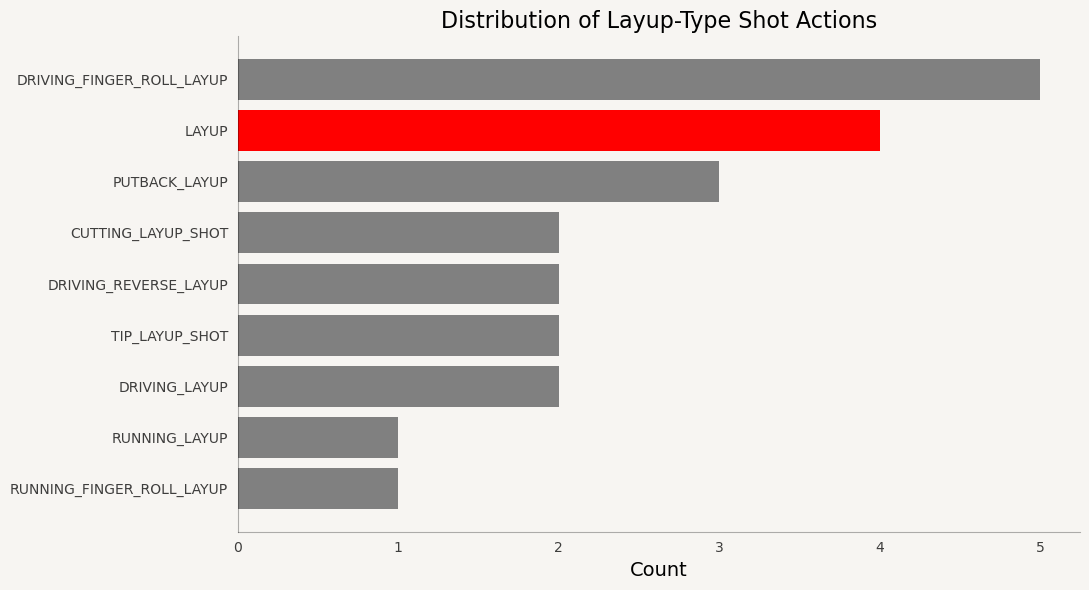

In [135]:
# Get count of all layup types
layup_counts = dfPlayers["SHOTACTION"][dfPlayers["SHOTACTION"].str.contains("LAYUP")].value_counts(ascending=True)

# Set color: red for 'LAYUP', default for others
colors = ['red' if action == 'LAYUP' else 'gray' for action in layup_counts.index]


fig, ax = plt.subplots(figsize=figsize)

ax.barh(layup_counts.index, layup_counts.values, color=colors)

ax.set_xlabel('Count', fontsize=labelsize)
ax.set_title('Distribution of Layup-Type Shot Actions', fontsize=titlesize)
plt.tight_layout()
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

tidy_axes(ax)
plt.savefig("../images/module2_images/layup_types.png")

plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


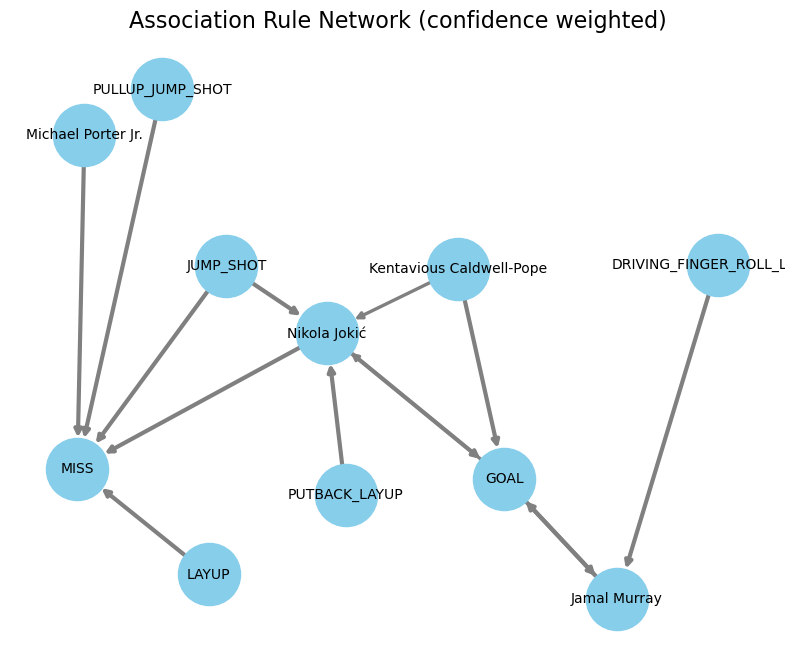

In [199]:
# Create a network figure
G = nx.DiGraph()

frame = conf.head(10)
metric = "confidence"
# Add edges for whichever rule desired
for _, row in frame.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(str(ant), str(con), weight=row[metric])

# Draw network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)

# Edge weights as thickness
weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
                 width=weights, node_size=2000, font_size=10, arrows=True)

plt.title("Association Rule Network (confidence weighted)", fontsize=titlesize)
plt.axis('off')
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/network.png")

plt.show()